## Inference and Decisions

We have been talking about probability and have some tools under our belt for manipulating distributions and estimating parameters.  How do we turn this into a decision?  Here we will discuss some measures that might help inform that decision.

  
General references:
  
+ Statistical Inference (9780534243128): Casella, George, Berger, Roger L.  
+ Probability Theory and Statistical Inference: Empirical Modeling with Observational Data (9781107185142): Spanos, A.  
+ Bayesian Models: A Statistical Primer for Ecologists (9780691159287): Hobbs, N. Thompson, Hooten, Mevin B.  
+ A First Course in Bayesian Statistical Methods (0387922997): Hoff, Peter D.
  

<br>
<br>
<hr style="border:2px solid blue"> </hr>

### Classification

In the last section, we gave an example taking of a test for determining status of disease.  We took the test and discovered a positive result which led to a probability that we are truly infected given the postivite test of 79%.  The odds are, we have the disease.  Are we sure enough that we will seek appropriate treatment or perhaps we want a second opinion?  Is there a second test?  Do we simply take two tests and combine the results?  When we build a computational model, we repeatedly ask this question and have to make a decision, do we continue in the current direction or go from whence we came. The consequences of making a wrong choice are often not symmetric.  Our overall goal is to simply be right, but understanding consequence discrepancies may suggest wrong answers are not all the same.  In this example we may choose to weigh a wrong answer differently in one direction than another.

Restating this in terms of probability, for a binary decision, our goal is:

\\(\text{argmin } p(mistake) = \sum_{i=1}^k p(x_{k \notin j},C_k)\\) where j/k are class labels.

#### Rejection regions or decision boundaries

In our decision, we may choose a region for inclusion in one class or another, for instance, we may decide the optimal boundary in our disease classification is at $p(disease|+test)>75%$.  Note that the decision boundary should parition the space.  Written with a decision boundary, 

$$\text{argmin } p(mistake) = \int_{\mathbb{R_1}} p(x,C_2) dx + \int_{\mathbb{R_2}} p(x,C_1) dx$$


Returning to the coin toss experiment, after we perform the experiment many times, we can arrange the data and find the regions to the right/left that give the desired partions between 'fair' and 'biased' based on our tolerance for error.

bounds are:
[0.35, 0.6]


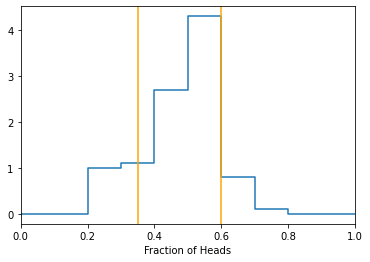

In [2]:
import numpy as np
import random as random
import matplotlib.pyplot as plt

# define an experiment as flipping Ncoins
# we will repeat the experiment Ntrials times
# for each experiment, we record the fraction of heads(1's) observed

def do_one_trial(pheads=0.5, Ncoins=10):
    coin = [1,0] #H=1, T=0
    total_flips = 1000 
    toss_results = random.choices(coin,k=Ncoins,weights=[pheads,1-pheads])
    fraction_successes = float(sum(toss_results)/Ncoins) # success = head
    return fraction_successes

def do_many_trials(pheads=0.5, Ntrials=1000, Ncoins=20):
    resultarr = []
    for i in range(0, Ntrials):
        resultarr.append(do_one_trial(pheads=pheads, Ncoins=Ncoins))
    return resultarr

# looking to get the bounds of the rejection region for plotting
def get_thresh_2tail(trial_data, significance=.1):
    sorted_results = np.array(sorted(trial_data))
    twotailedsig = significance/2.
    # sum from left to right to find left most bound
    for val in sorted_results:
        integral = float(len(sorted_results[sorted_results<val]))/len(sorted_results)
        if integral > twotailedsig:
            lowerbound = val
            break
    # sum from right to left to find right most bound
    for val in sorted_results[::-1]:
        integral = float(len(sorted_results[sorted_results>val]))/len(sorted_results)
        if integral > twotailedsig:
            upperbound = val
            break
    return lowerbound, upperbound

coin_experiment_data = do_many_trials(pheads=0.5, Ntrials=100, Ncoins=20)
lowerbound, upperbound = get_thresh_2tail(coin_experiment_data, significance=0.1)

# plot data with rejection regions
hist, bins = np.histogram(coin_experiment_data, bins = np.linspace(0,1,11), density=True)
hist = np.concatenate([hist,[0.]])
plt.plot(bins, hist, drawstyle='steps-post')
plt.xlabel('Fraction of Heads')
plt.axvline(lowerbound, color='orange')
plt.axvline(upperbound, color='orange')
plt.xlim(0, 1)

print("bounds are:")
print([lowerbound, upperbound])
plt.show()

Knowing we are going to make mistakes, we introduce the idea of a loss function.  Loss functions (also called cost functions or as a positive, a utility functions), is a function that we create that captures the goal of minimizing errors but allows for differences in magnetude for consequences of the mistakes.  The goal is now to minimize the average loss:

$$E[loss] = \sum_k \sum_j \int_{\mathbb{R_j}} L_{kj}p(x,C_k) dx$$


#### Loss functions

Loss functions are functions created to match our goals with penalties to steer our algorithm to beneficial regions.  As an example, consider the follow loss function:

$$\begin{matrix} & \text{disease} & \text{no disease} \\ \text{disease} & 0 & 100 \\\text{no disease} & 1 & 0 \end{matrix}$$

Here we are assigning zero loss for correct responses, 1 loss for cases where we predict "no disease" but the true state is "disease" and finally, 100 loss for cases of incorrectly predicting "disease".  The loss function here is implicitly penalizing false positives more than false negatives (see Confusion Matrix at end).

$$L(\theta,a) = 
\begin{cases}
    0, \text{for {(predict disease, actual disease),(predict no disease, actual no disease)}} \\
    1, \text{for predict no disease, actual disease} \\
    100, \text{for predict disease, actual no disease} \\
\end{cases}
$$


#### Cross Entropy Loss

Any loss function which is the negative log likelihood between the empirical distribution of the data and the probability distribution of the model is a cross entropy loss.

Often, when one talks about cross entropy loss, the meaning is for binary classification.  In fact, cross entropy loss, also called log loss, is the go-to function for binary classification tasks.  It is the log likelihood for a Bernoulli trial.

$$-y_i ln(\hat{\theta}_i) - (1-y_i) ln (1-\hat{\theta}_i)$$

Cross entropy loss is nice in that it penalizes heavily for very wrong results.  In this case, the true labels are the \\(y_i\\)'s while our predictions are the associated probabilities (\\(\hat{\theta}_i\\)'s). Note, there is no 'reward' in cross entropy loss, the best you can do is 0 when the output is correct.



In [3]:
import numpy as np
predictions = np.array([[0.95,0.05],
                        [0.15,0.85],
                        [0.75,0.25],
                        [0.04,0.96]]) #predictions are A,B,B,A
targets = np.array([[1,0],
                    [1,0],
                    [0,1],
                   [0,1]]) #correct classes are A,A,B,B

epsilon=1e-10 # avoid log of zero
predictions = np.clip(predictions, epsilon, 1. - epsilon)
N = predictions.shape[0]
x = targets * np.log(predictions+1e-7)
print("Penalties for each prediction")
print(x)
ce_loss = -np.sum(x)/N
print ("Total cross entropy loss is: " + str(ce_loss))


Penalties for each prediction
[[-0.05129319 -0.        ]
 [-1.89711932 -0.        ]
 [-0.         -1.38629396]
 [-0.         -0.04082189]]
Total cross entropy loss is: 0.8438820897043499


Note that this can easily be extended to the case of multiple categories.

#### Categorical cross entropy loss

$$\text{CE loss }= - \sum_{i=1}^I \sum_{k=1}^K \mathbb{1}_{y_i = k}log p(y_i = k | x_i,\theta)$$

This looks completely different, but understanding the terms will quickly lead to a familiar setup.  The CE loss is a sum of the probabilities assigned to the predicted class.  The \\(\mathbb{1}\\) is an idicator function determining which class is the correct class while the \\(p(y_i = k | x_i,\theta)\\) is the likelihood of the correct class given the data.  In the case of two categories, this reduces to the cross entropy case above.


#### Other classification loss functions

**Focal loss** is a modified loss attempting to highlight the loss from incorrectly classified samples vs those that are classified correctly, but perhaps with less than perfect probability.

$$FL = - \sum_{i=1}^{C=2}(1-\hat{\theta}_i)^\gamma t_i log(\hat{\theta}_i)$, where $(1-\hat{\theta}_i)^\gamma$$

modulates the loss.  As the probability of the assignment goes towards 1 for correct responses, the contribution to the loss goes to 0 more quickly.

**Hinge loss** is a maximum margin classifier.  Basically, this loss aims to make the classification more of a sure event.  The score of a correct assignment should exceed the sum of scores of incorrect assignments by some margin.

$$HL = \sum_{j \ne y_i} max(0,s_j-s_{y_i}+1)$$

#### Continuous response

In continuous responses, the goodness of fit measure is some function of distance.  

##### Mean squared error 

Mean squared error, MSE, is defined as 

$$MSE = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y_i})^2$$

This has a number of nice features as a loss function including penalizing based on distance from the prediction and mathmatical properties such as that it is differentiable and there is always a single solution.  MSE is sensitive to outliers, ie it is not robust to outliers.

##### Mean absolute error 

Mean absolute error, MAE, is defined as 

$$MAE = \frac{1}{N} \sum_{i=1}^N |y_i - \hat{y_i}|$$

Like MSE, MAE returns the average of the magnetude of errors, but needs computational tools to deal with the lack of a differential.  MAE is less sensitive to ouliers than MSE, however, there is no guarantee of a unique solution.

##### L1 and L2 loss

L1 loss is sum of absolute differences, also called the method of Least Absolute Deviations (LAD).  \\(L_1 = N \ast MAE\\).  

L2 loss is \\(N \ast MSE\\) also called least squares error, or LSE.

##### Regularization 

Regularization is a technique to prevent overfitting throug addition of penatly term to the sum of the regression coefficents.  For instance:

\\(argmin LSE + \lambda \sum_{i=1}^k|w_i|\\), where the \\(w_i\\) are the weights being learned.

The above woulld be an L1 regularization on least squares (LASSO).  There are other variations including L2 regularization (ridge regression) where the penalty is on the squared weights, elastic net (both L1 and L2 regularization), etc.


### Confusion matrix

For binary classification problems, we have the so called confusion matrix.  For a class known to be A, did we predict A or B?  The result to that question can be summarized in the confusion matrix:


|                     | Positive Class                    | Negative Class                       |
|---------------------|-----------------------------------|--------------------------------------|
| Positive Prediction | True Positive (TP)                | False Positive (FP) **Type I error** |
| Negative Prediction | False Negative (FN) **Type II error** | True Negative (TN)              |

The various cells give rise to the 4 possible cases: TP,FP,FN,TN.  Associated with these cases are marginal rates:

True Positive Rate (TPR): TP/(TP+FN)  -- **Sensitivity**  
False Positive Rate (FPR): FP/(FP+TN)  
True Negative Rate (TNR): TN/(TN+FP)  -- **Specificity**  
False Negative Rate (FNR): FN/(FN+TP)

As an aside, we can map these to Bayes' Rule where

P(A) = Probability of Positive Class (PC)  
P(not A) = Probability of Negative Class (NC)  
P(B) = Probability of Positive Prediction (PP)  
P(not B) = Probability of Negative Prediction (NP)  

$$P(A|B) = \frac{P(B|A)*P(A)}{P(B)} = \frac{TPR*PC}{TPR*PC + FPR*NC}$$


Precision also called the Positive Predictive Value.  
$$precision = PPV = \frac{TP}{TP+FP} = \frac{TPR*PC}{PP}$$

Recall is also known as the sensitivity.  
$$recall = \frac{TP}{TP+FN}$$

$$F_1 score = \frac{precision*recall}{precision+recall}$$

Type 1 error = false positive

Type 2 error = false negative

<br>
<br>
<hr style="border:2px solid blue"> </hr>

### UNGRADED EVALUATION (20 min)

#### 1. Categorical cross entropy can be used when multiple classes are to be differentiated.  For each sample, you expect the output of the algorithm to give

    a. A single probability giving the probability of being correct  
    
    b. Multiple probabilities representing the probability of assignment to each class    
    
#### 2. Mean squared error is an example of

    a. A continuous loss function penalizing wrong answers by the squared distance between true and predicted repsonse.     
    
    b. A mathmatical construct representing the mean number of responses incorrectly predicted in a classification problem.
    
#### 3. Cross entropy loss gives a penalty to incorrectly classified samples and rewards correct classification.

    a. false    
    b. true


#### 3. You are building a classifier to classify dogs vs cats.  Where dogs =1, your algorithm is presented with the following set of images {1 0 1 0 1 0 0 1 1 1} and gives the following predictions {1 0 0 0 1 1 1 0 0 1}.  With respect to classifying dogs, the sensitivity is:

    a. 0.5     
    
    b. 0.83 
    
    c. 6

#### 4. In the dog classification problem, correctly classifying cats as cats will give the

    a. true positives 
    
    b. false positives  
    
    c. false negatives  
    
    d. true negatives     

#### 5.  You are building a spam classifier, 

    a. false positives are more problematic than false negatives  
    
    b. false negatives are more problematic than false positives  
    
    c both false positives and false negatives are equally problematic     

#### 6. In your spam classifier, you choose to weight the choice as spam or not differently, you should  

    a. choose a penalized regression to dampen the weights 
    
    b. choose a custom categorical loss function to allow setting importance of decisions      



### GRADED EVALUATION (15 mins)

1. Cost functions are measures of fit.  

    a. true     
    
    b. false 

2. Cost functions are only useful in categorical decision settings.

    a. false      
    
    b. true

3. The following is a valid example of a cost function:

    a. 

    $$L(\theta,a) = 
    \begin{cases}
        0, \text{for {(predict disease, actual disease),(predict no disease, actual no disease)}} \\
        1, \text{for predict no disease, actual no disease} \\
        100, \text{for predict disease, actual no disease} \\
    \end{cases}
    $$

    b.   

    $$L(\theta,a) = 
    \begin{cases}
        0, \text{for {(predict disease, actual disease),(predict no disease, actual no disease)}} \\
        1, \text{for predict no disease, actual disease} \\
        100, \text{for predict disease, actual no disease} \\
    \end{cases}
    $$

2. In a recent study, you created a cost function for classification of 4 classes.  Following training, you obtained the following resuls.  What are the predictions for the samples in terms of thier class?

    predictions = np.array([[0.25,0.25,0.20,0.30],
                            [0.25,0.30,0.20,0.25],
                            [0.10,0.25,0.25,0.40],
                            [0.45,0.10,0.20,0.25],
                            [0.01,0.01,0.01,0.96]])

    a. A,B,C,B
    
    b. D,B,D,A,D   
    
    c. D,B,C,E

